In [1]:
import warnings
from unicodedata import normalize

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tools as fc

**Configuraciones**


In [2]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Materiales extraidos en Colombia'
warnings.filterwarnings("ignore")

**Data**

In [3]:
url_master =  'https://drive.google.com/uc?id=' 
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'
url_department = 'https://drive.google.com/file/d/1fKM6yk_oxEsjJyZhOsSjmdcryN7Y50RK/view?usp=sharing'
url_type_miner = 'https://drive.google.com/file/d/1Q69MPSg8joI1nZz6CYwxa0_DdUGquRU2/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
url_department =  url_master + url_department.split('/')[-2]
url_type_miner =  url_master + url_type_miner.split('/')[-2]


data_miner = pd.read_csv(url_minero, dtype=str)
data_department = pd.read_csv(url_department, dtype=str)
data_type_miner = pd.read_csv(url_type_miner, dtype=str)

In [4]:
data_miner.columns =[
        'city',
        'state',
        'natural_resource',
        'name_project',
        'year_exploitation',
        'quarter',
        'unit_measurement',
        'type_compensation',
        'value_compensation',
        'production_quantity'
    ]

In [5]:
data_department.columns = [
    'code_state',
    'code_city',
    'state',
    'city',
    'region',
    'access_sea'
]

In [6]:
data_type_miner.columns = [
    'natural_resource',
    'first_clasification',
    'second_clasification',
]

In [7]:
data_miner.head(1)

,city,state,natural_resource,name_project,year_exploitation,quarter,unit_measurement,type_compensation,value_compensation,production_quantity
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0


In [8]:
data_department.head(1)

,code_state,code_city,state,city,region,access_sea
0,5,5001,ANTIOQUIA,MEDELLÍN,Andina,Si


In [9]:
data_type_miner.head(1)

,natural_resource,first_clasification,second_clasification
0,ARCILLAS,Rocas sedimentarias,NaN


**Data Processing**



must have consistency in the fields jurisdiction in all tables. that's why  they are  convert the values in upper and without accent

In [10]:
data_miner['city'] = data_miner['city'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

data_miner['state'] = data_miner['state'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

data_department[
    'state'] = data_department['state'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

data_department[
    'city'] = data_department['city'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

Normalization of names of the columns

In [11]:
columns = fc.normalize_name_columns(data_miner.columns)
data_miner.columns = columns

columns = fc.normalize_name_columns(data_department.columns)
data_department.columns = columns

columns = fc.normalize_name_columns(data_type_miner.columns)
data_type_miner.columns = columns

change the type of columns, since, all types the features  are object

In [12]:
data_miner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55257 entries, 0 to 55256
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 55257 non-null  object
 1   state                55257 non-null  object
 2   natural_resource     55257 non-null  object
 3   name_project         55257 non-null  object
 4   year_exploitation    55257 non-null  object
 5   quarter              55257 non-null  object
 6   unit_measurement     55257 non-null  object
 7   type_compensation    55257 non-null  object
 8   value_compensation   55257 non-null  object
 9   production_quantity  55257 non-null  object
dtypes: object(10)
memory usage: 4.2+ MB


In [13]:
data_miner[[
    'value_compensation',
    'production_quantity']] = data_miner[[
    'value_compensation',
    'production_quantity']].astype('float64')
data_miner[
    'year_exploitation'] = data_miner[
    'year_exploitation'].astype('int64')

Joiner the tables

In [14]:
data_processing = pd.merge(
    data_miner, 
    data_department, 
    on=['city', 'state'], 
    how='left').drop(
        columns=[
            'code_state',
        ]
    ).drop(columns=['access_sea'])

In [15]:
data_miner.columns

Index(['city', 'state', 'natural_resource', 'name_project',
       'year_exploitation', 'quarter', 'unit_measurement', 'type_compensation',
       'value_compensation', 'production_quantity'],
      dtype='object')

In [16]:
data_processing = pd.merge(
    data_processing,
    data_type_miner,
    left_on=['natural_resource'],
    right_on=['natural_resource'],
    how='left'
)

In [17]:
data_processing.shape

(55257, 14)

In [18]:
data_processing.head(1)

,city,state,natural_resource,name_project,year_exploitation,quarter,unit_measurement,type_compensation,value_compensation,production_quantity,code_city,region,first_clasification,second_clasification
0,MEDELLIN,ANTIOQUIA,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,"614,258.00",0.00,5001,Andina,Rocas sedimentarias,NaN


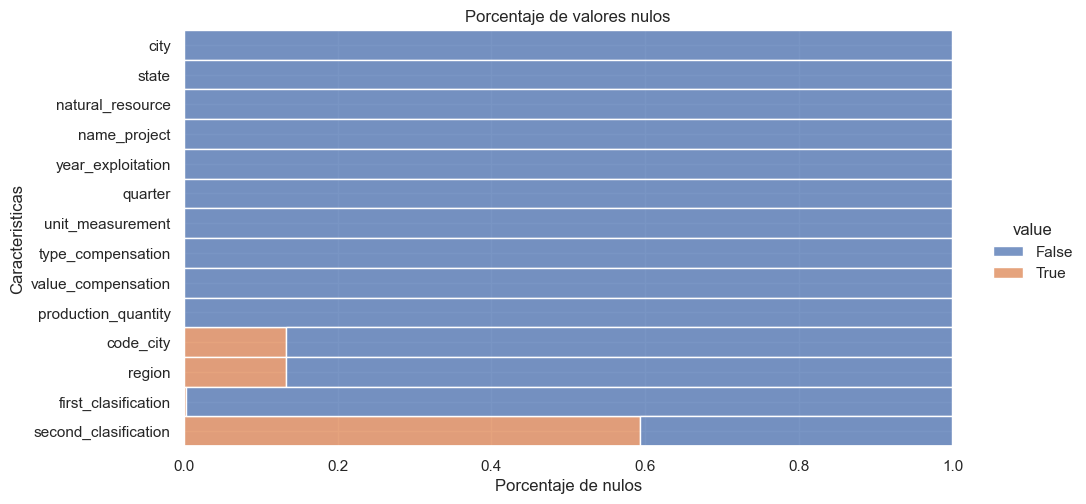

In [19]:
fc.porcentaje_nulos_x_caracteristica(
    data_processing, 
    title="Porcentaje de valores nulos", 
    xlabel='Porcentaje de nulos', 
    ylabel='Caracteristicas')

Text(0.5, 1.0, 'zoom')

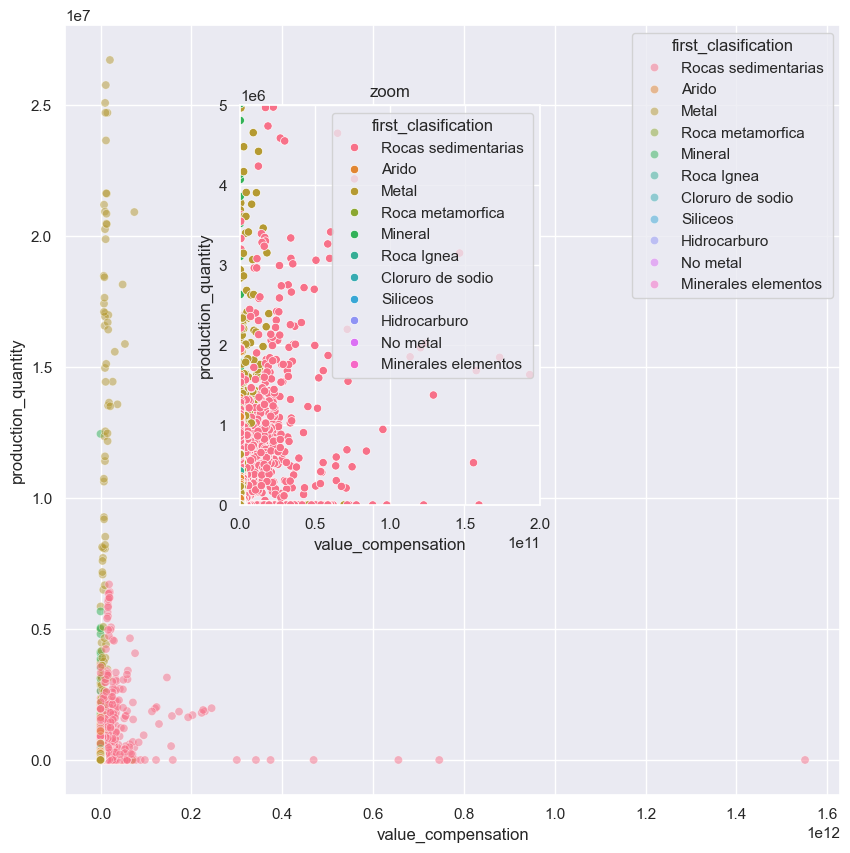

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(
    data=data_processing, 
    x="value_compensation", 
    y="production_quantity",
    hue='first_clasification',
    alpha=0.5,
    ax=ax)

ax2 = plt.axes([.3, .4, .3, .4])
sns.scatterplot(
    data_processing, 
    x="value_compensation", 
    y="production_quantity",
    hue='first_clasification',
    ax=ax2)
ax2.set_ylim([0.0,5000000.0])
ax2.set_xlim([0.0,200000000000.0])
ax2.set_title('zoom')

Text(0.5, 1.0, 'zoom')

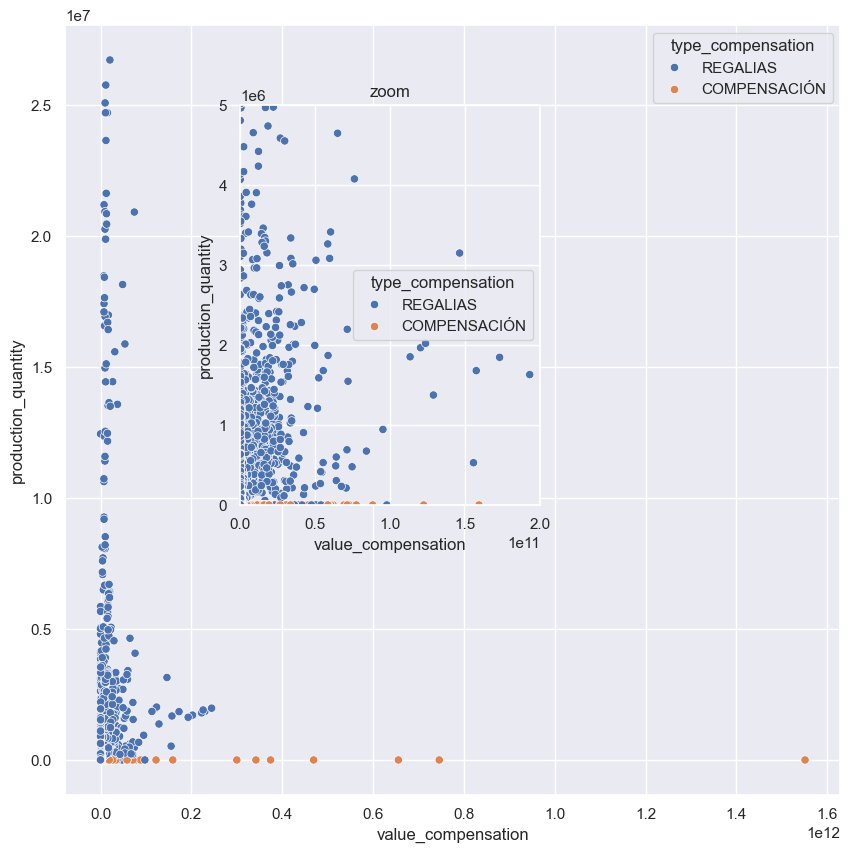

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    data=data_processing, 
    x="value_compensation", 
    y="production_quantity",
    hue='type_compensation')
ax2 = plt.axes([.3, .4, .3, .4])
sns.scatterplot(
    data_processing, 
    x="value_compensation", 
    y="production_quantity",
    hue='type_compensation',
    ax=ax2)
ax2.set_ylim([0.0,5000000.0])
ax2.set_xlim([0.0,200000000000.0])
ax2.set_title('zoom')

**Transactions**

In [22]:
function_dictionary = {
    'value_compensation':['sum', 'count']
}

data_transaction = data_processing.groupby([
    'city',
    'state',
    'year_exploitation',
    'quarter'
]).aggregate(
    function_dictionary
)

data_transaction.columns = [
    'sum_value_compensation',
    'count_n_transactions'
]

data_transaction.reset_index(inplace=True)


function_dictionary = {
    'sum_value_compensation':['sum', 'mean', 'median', 'std'],
    'count_n_transactions': ['sum', 'mean', 'median', 'std'],
    'quarter': ['count']
}

data_transaction = data_transaction.groupby([
    'city',
    'state'
]).aggregate(function_dictionary)


data_transaction.columns = [
    'sum_transactions_value',
    'mean_transactions_value',
    'median_transactions_value',
    'std_transactions_value',
    'sum_n_transactions',
    'mean_n_transactions',
    'median_n_transactions',
    'std_n_transactions',
    'count_quarter'
]


data_transaction.reset_index(inplace=True)

In [23]:
data_transaction

,city,state,sum_transactions_value,mean_transactions_value,median_transactions_value,std_transactions_value,sum_n_transactions,mean_n_transactions,median_n_transactions,std_n_transactions,count_quarter
0,ABEJORRAL,ANTIOQUIA,"367,731,680.00","12,257,722.67","5,682,074.50","17,677,666.01",61,2.03,2.00,1.10,30
1,ABREGO,NORTE DE SANTANDER,"39,316,798.00","1,191,418.12","1,041,894.00","875,453.51",43,1.30,1.00,0.53,33
2,ABRIAQUI,ANTIOQUIA,"409,521,514.00","14,121,431.52","9,186,757.00","17,024,154.20",96,3.31,2.00,1.67,29
3,ACACIAS,META,"1,048,395,762.00","24,381,296.79","19,119,631.00","17,974,589.55",129,3.00,3.00,1.33,43
4,ACANDI,CHOCO,"11,553,386,769.00","641,854,820.50","423,595,357.50","803,314,986.18",47,2.61,3.00,1.33,18
...,...,...,...,...,...,...,...,...,...,...,...
849,ZARAGOZA,ANTIOQUIA,"77,944,352,400.00","1,694,442,443.48","1,554,716,953.00","863,883,245.54",267,5.80,6.00,1.92,46
850,ZARZAL,VALLE DEL CAUCA,"22,865,346.00","879,436.38","733,329.00","885,107.44",33,1.27,1.00,0.53,26
851,ZETAQUIRA,BOYACA,"41,859.00","20,929.50","20,929.50","18,573.57",2,1.00,1.00,0.00,2
852,ZIPAQUIRA,CUNDINAMARCA,"11,853,105,060.00","263,402,334.67","101,407,038.00","375,484,196.59",138,3.07,3.00,1.18,45
